In [110]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale

import xgboost as xgb
import xgbfir
import lightgbm as lgb

import hyperopt as hp

In [111]:
data_awake = pd.read_excel('data/awake.xls')

In [112]:
# data_awake = data_awake[data_awake['spike_count'] > 500]

In [113]:
data_awake = data_awake.drop(['doc_name', 'interval_name', 'data_name', 'spike_count', 'filter_length'], axis=1)

In [114]:
data_sleep = pd.read_excel('data/sleep.xls')

In [115]:
data_sleep = data_sleep.drop(['doc_name', 'data_name', 'interval_name', 'spike_count', 'filter_length'], axis=1)

In [116]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

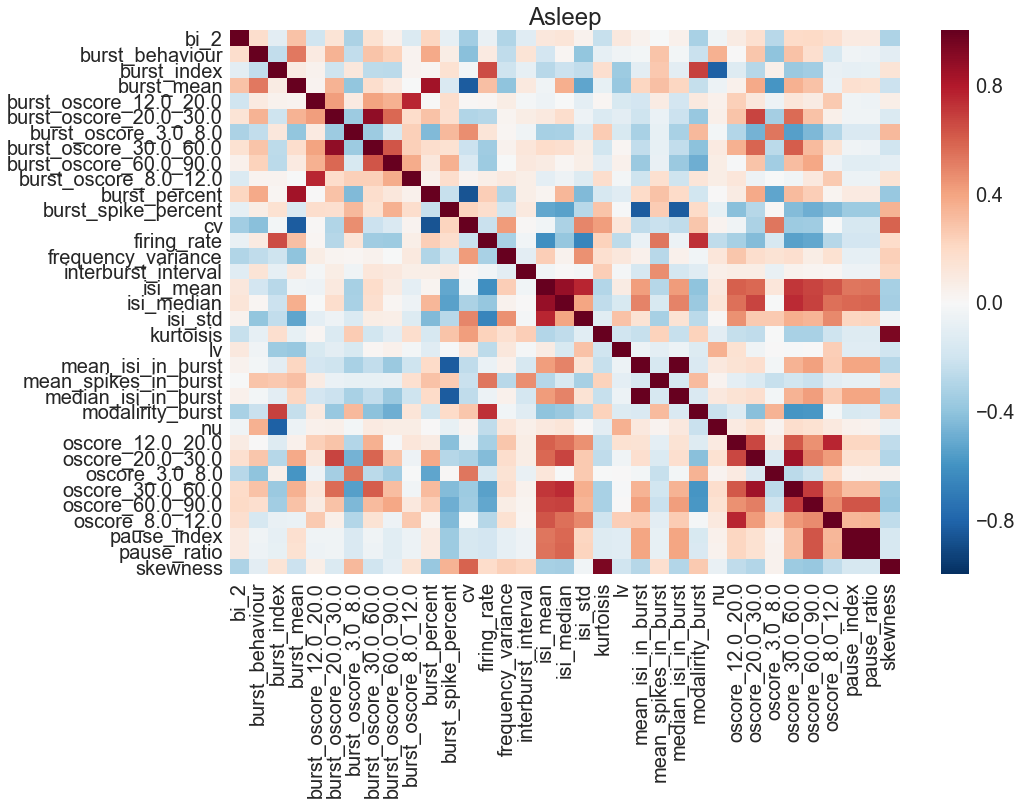

In [117]:
plt.figure(figsize=(15,10))
sns.heatmap(data_sleep.corr())
plt.title('Asleep')

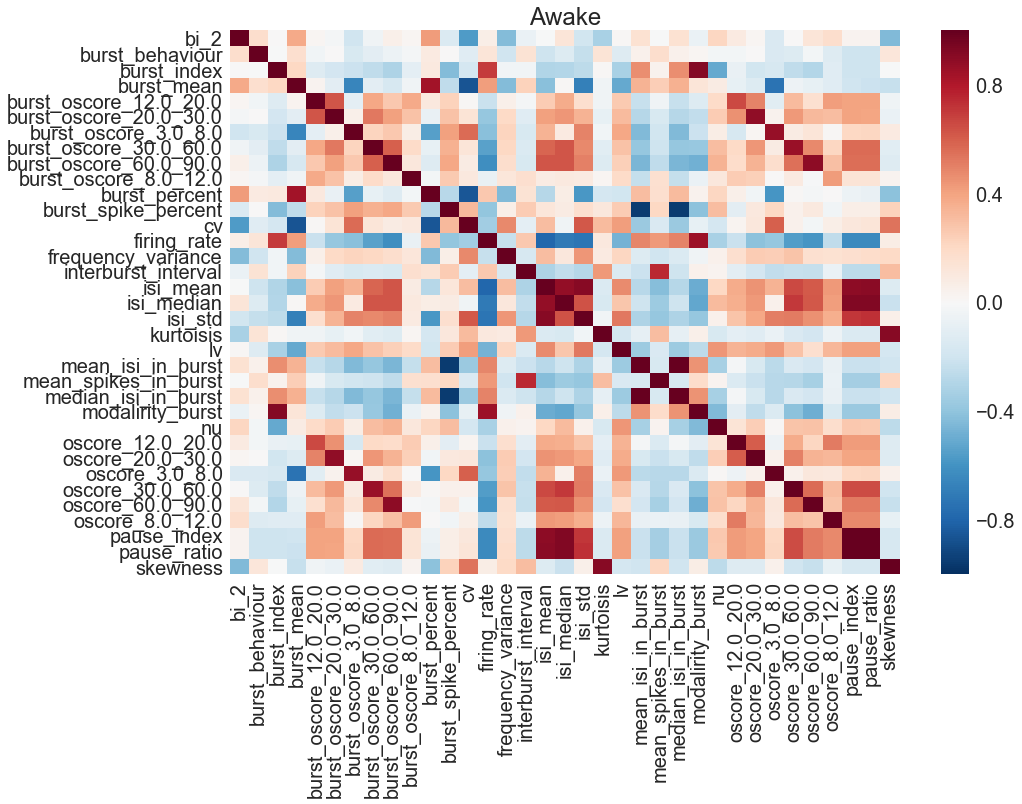

In [118]:
plt.figure(figsize=(15,10))
sns.heatmap(data_awake.corr())
plt.title('Awake')

In [119]:
data_sleep['awake'] = 0
data_awake['awake'] = 1

data = pd.concat([data_sleep, data_awake], ignore_index=True)
# data = data.join(pd.get_dummies(data['type'])).drop(['type'], axis=1)

In [120]:
patients = data['patient']
data = data.drop(['burst_index',  'patient', 'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio'], axis=1)

In [121]:
data.to_csv('data_cleaned.csv', index=False)

In [122]:
data = data[data['burst_oscore_3.0_8.0'] > 0]

In [58]:
X = data.drop(['awake'], axis=1)
y = data['awake']

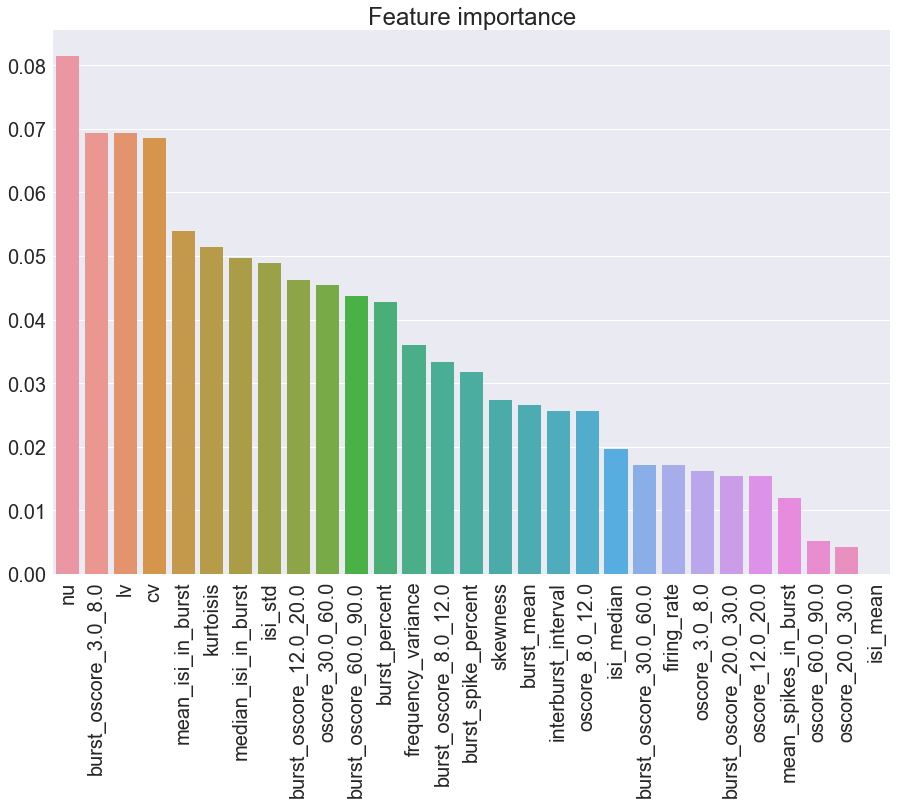

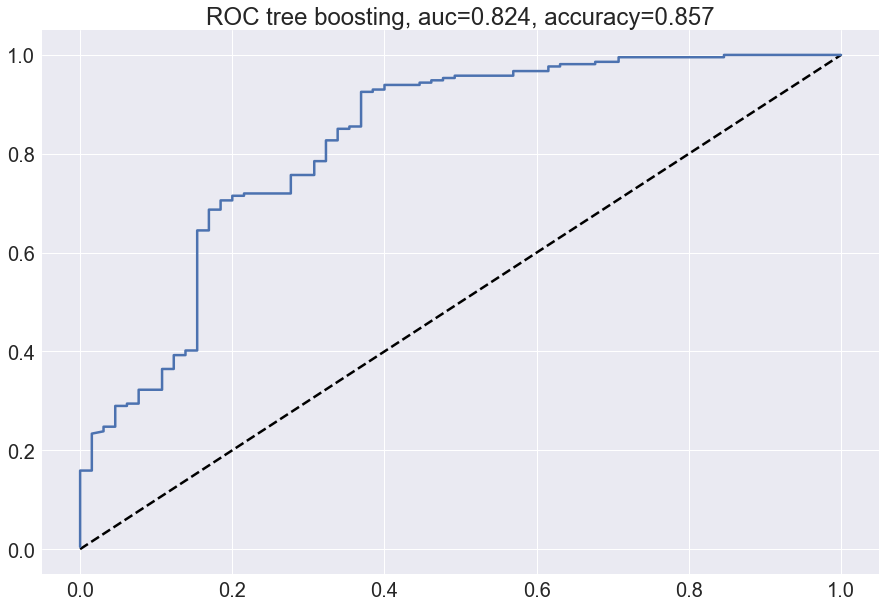

In [60]:
model = xgb.XGBClassifier(learning_rate=0.125, max_depth=3, n_estimators=400)
model.fit(X, y)

fig, ax = plt.subplots(figsize=(15,10))
_ = plt.xticks(rotation=90)

features = sorted(zip(X.columns.values, model.feature_importances_), key = lambda x: x[1], reverse=True)

sns.barplot([f[0] for f in features], [f[1] for f in features])
acc = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
plt.title('Feature importance')


probs = cross_val_predict(model, X, y, method='predict_proba', cv=5)[:,1]
fpr, tpr, _ = roc_curve(y, probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(15,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC tree boosting, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))

In [57]:
xgbfir.saveXgbFI(model.booster(), feature_names=X.columns.values, OutputXlsxFile = 'awake_interactions_depth_3.xlsx')

In [32]:
col_names = X.columns.values
X = scale(X)

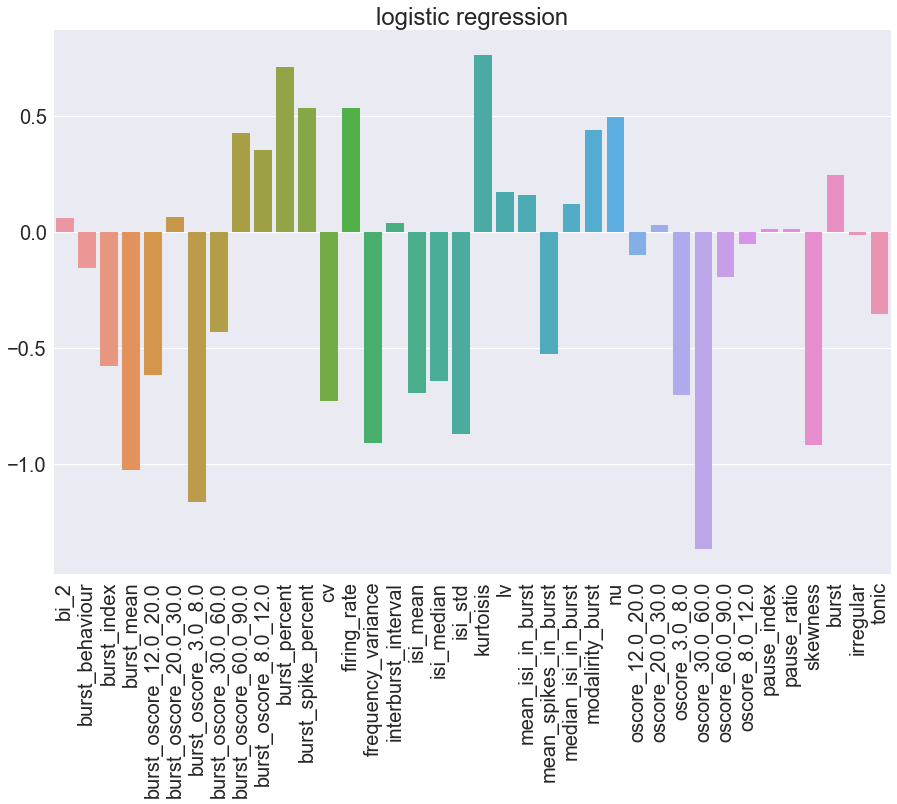

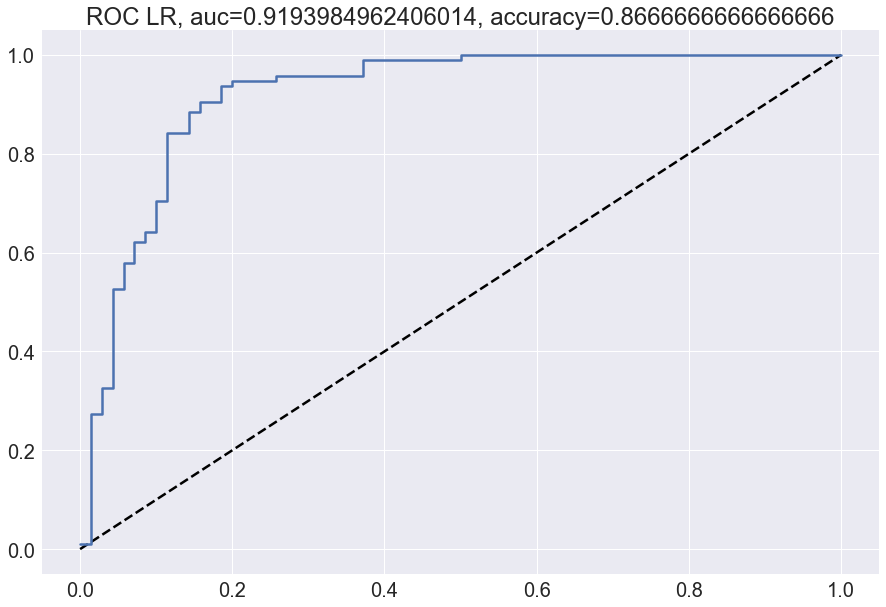

In [34]:
LR = LogisticRegression()
LR.fit(X, y)

plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.barplot(col_names, LR.coef_[0])
acc = np.mean(cross_val_score(LR, X, y, scoring='accuracy', cv=5))
plt.title('logistic regression')

probs = cross_val_predict(LR, X, y, method='predict_proba', cv=5)[:,1]
fpr, tpr, _ = roc_curve(y, probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(15,10))
plt.xticks(rotation=0)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC LR, auc={}, accuracy={}'.format(auc_score, acc))

In [107]:
oscore_cols = ['oscore_12.0_20.0',
       'oscore_20.0_30.0', 'oscore_3.0_8.0', 'oscore_30.0_60.0',
       'oscore_60.0_90.0', 'oscore_8.0_12.0']

burst_oscore_cols = [ 'burst_oscore_12.0_20.0', 'burst_oscore_20.0_30.0',
       'burst_oscore_3.0_8.0', 'burst_oscore_30.0_60.0',
       'burst_oscore_60.0_90.0', 'burst_oscore_8.0_12.0']

In [133]:
data_bursts = data
for c in burst_oscore_cols:
    data_bursts = data_bursts[data_bursts[c] > 0.]

In [134]:
data_bursts.shape

(270, 30)

In [135]:
np.log(data_bursts[oscore_cols])

,oscore_12.0_20.0,oscore_20.0_30.0,oscore_3.0_8.0,oscore_30.0_60.0,oscore_60.0_90.0,oscore_8.0_12.0
0,-1.081540,-0.254396,2.128371,0.490422,0.023476,0.289979
1,-1.582776,-0.717513,1.894652,-0.241023,0.457124,1.328194
2,-2.656263,-0.050647,2.351735,0.665001,0.975955,1.192039
4,0.570833,-0.550697,0.830350,-0.153073,-0.220880,0.887640
5,0.119496,0.088880,1.245658,-0.087473,-0.631470,0.273283
6,-1.373955,-0.327552,2.380409,-0.520959,-0.113817,0.482331
7,0.404185,-4.486975,2.138808,-2.276029,-1.118540,0.672647
9,-2.607054,0.572214,2.400413,0.077953,0.852455,-0.153960
10,1.301234,1.629263,0.477157,1.662978,-0.135668,-0.485933
11,0.957987,1.899707,0.235807,1.772047,0.852748,-0.330911


In [136]:
data_bursts[burst_oscore_cols]

,burst_oscore_12.0_20.0,burst_oscore_20.0_30.0,burst_oscore_3.0_8.0,burst_oscore_30.0_60.0,burst_oscore_60.0_90.0,burst_oscore_8.0_12.0
0,1.043102e-01,8.629091e-01,8.404066,2.011543,1.445615,3.000826e+00
1,2.143967e-01,5.877580e-01,6.220290,0.785658,1.373944,3.814761e+00
2,7.939461e-02,6.965564e-01,10.725603,1.944658,2.568901,3.227958e+00
4,1.763394e+00,5.782124e-01,2.153665,0.841524,0.809018,2.422302e+00
5,1.116519e+00,9.027369e-01,3.338165,0.969637,0.571966,1.325011e+00
6,2.295075e-01,6.653709e-01,10.927487,0.540373,0.805090,5.087708e-01
7,1.472789e+00,7.216770e-03,8.730080,0.027102,0.340369,1.937105e+00
9,5.034198e-14,1.707213e+00,10.548415,1.112388,2.257324,6.882082e-02
10,3.609127e+00,4.834933e+00,1.481909,5.224703,1.578371,2.455478e-14
11,2.832353e+00,6.929743e+00,0.943786,4.863629,2.655672,6.935403e-01


In [137]:
data_bursts[oscore_cols] = np.log(data_bursts[oscore_cols])
data_bursts[burst_oscore_cols] = np.log(data_bursts[burst_oscore_cols])

c:\Users\vladka\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


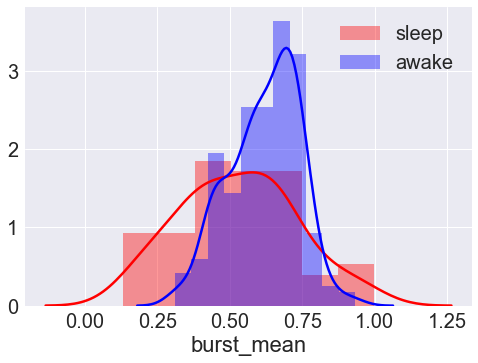

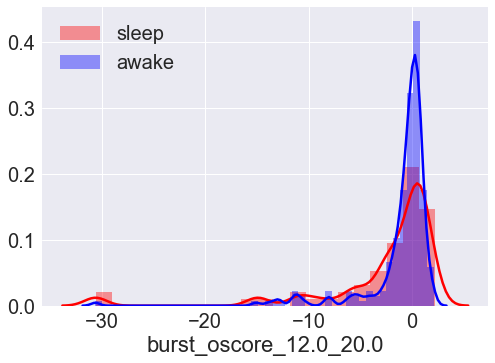

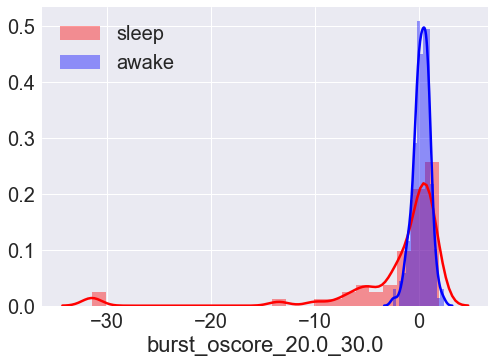

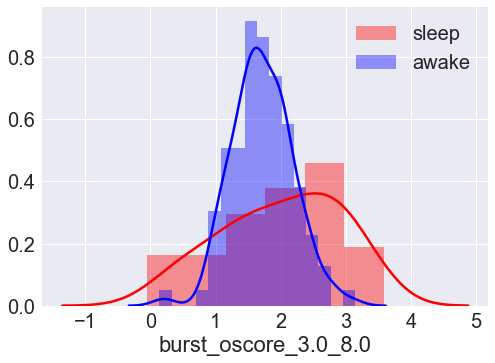

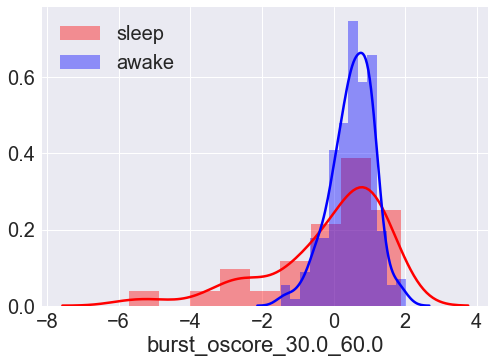

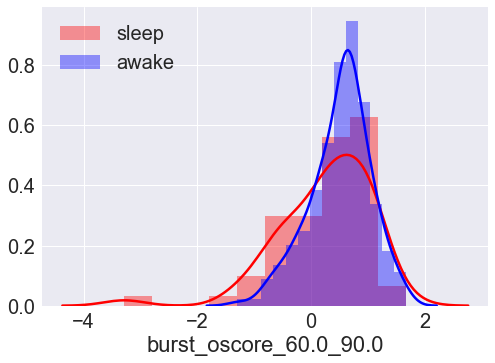

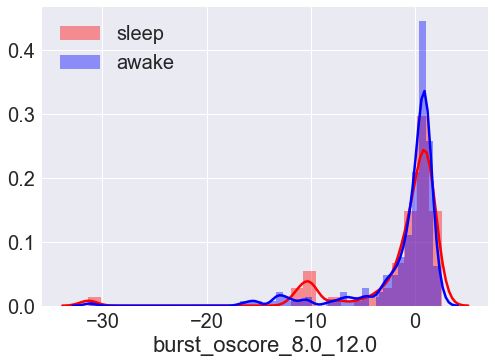

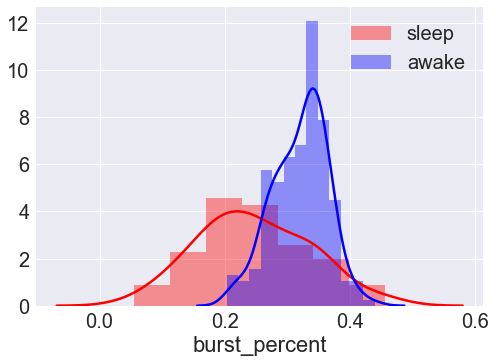

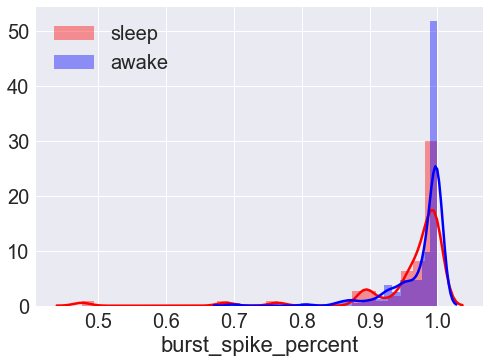

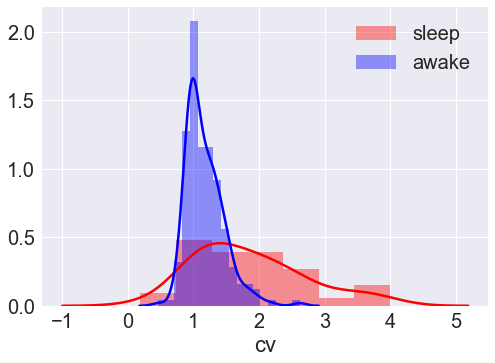

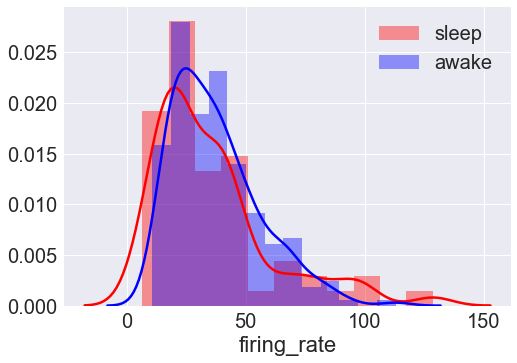

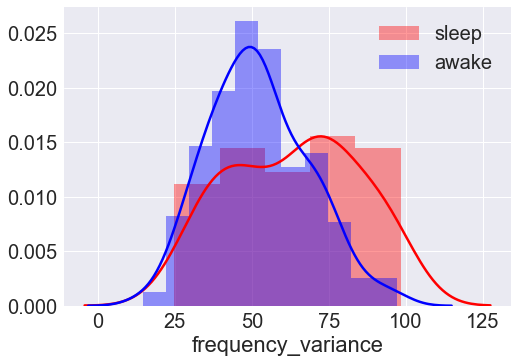

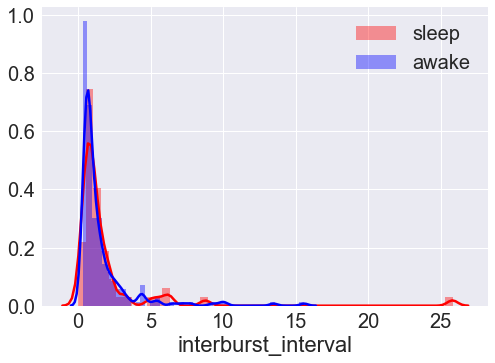

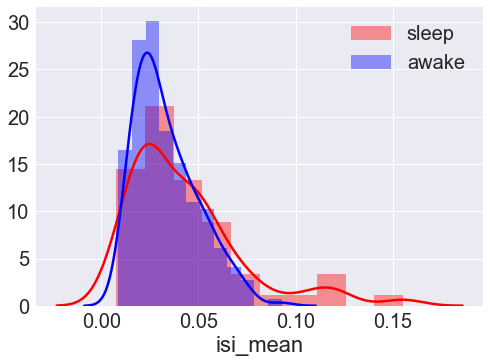

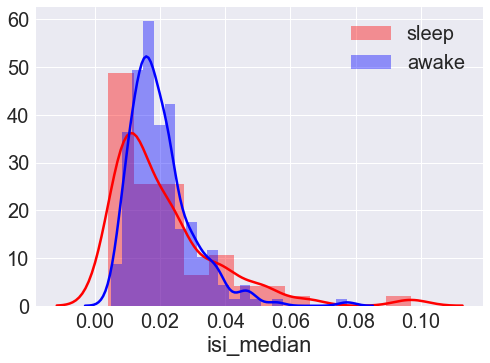

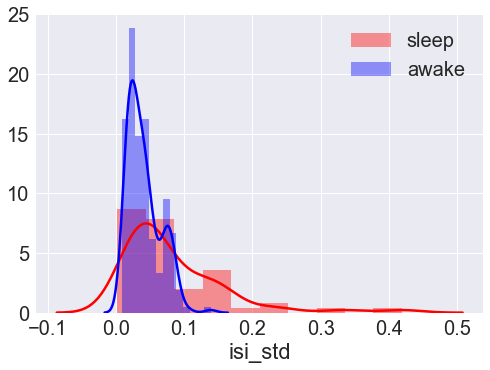

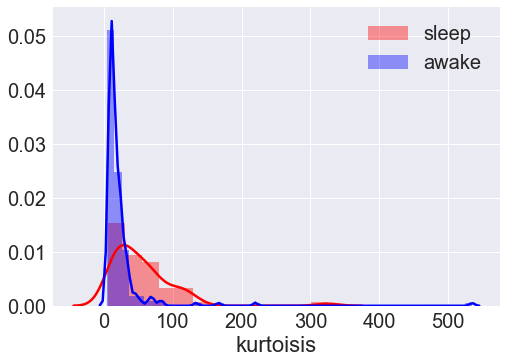

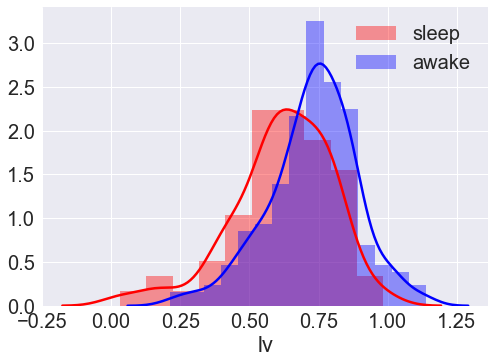

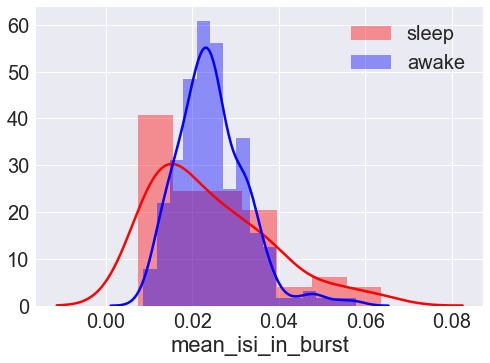

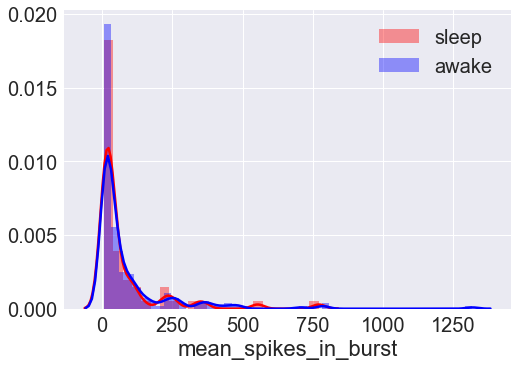

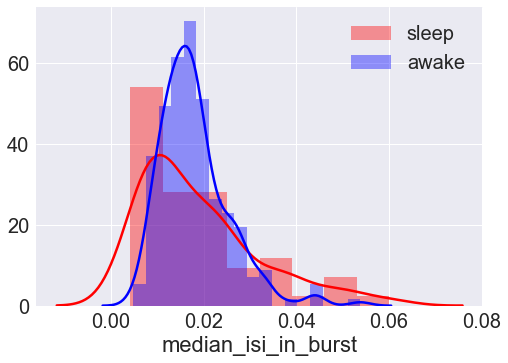

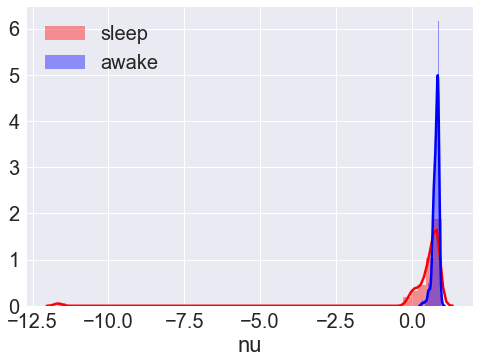

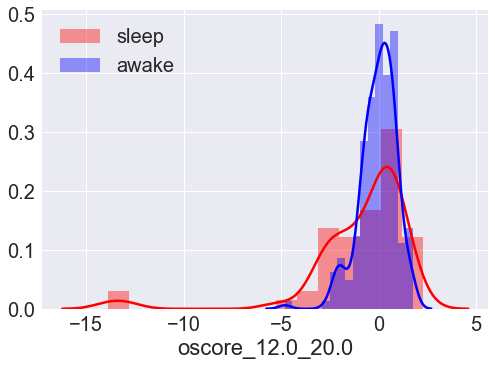

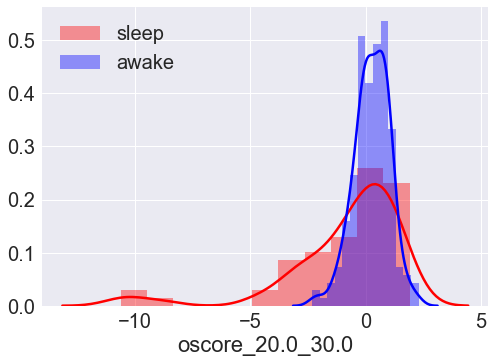

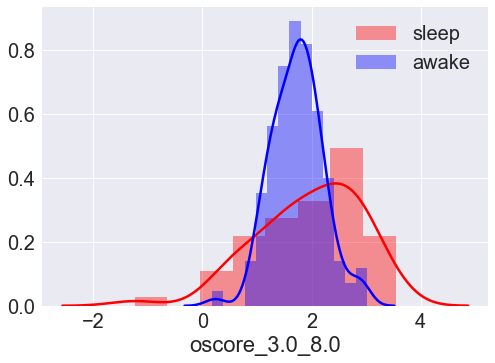

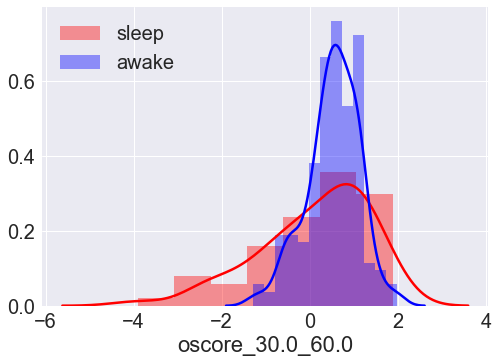

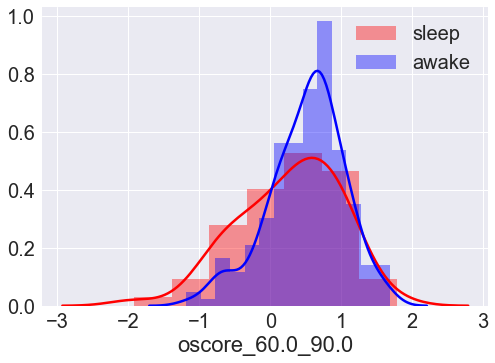

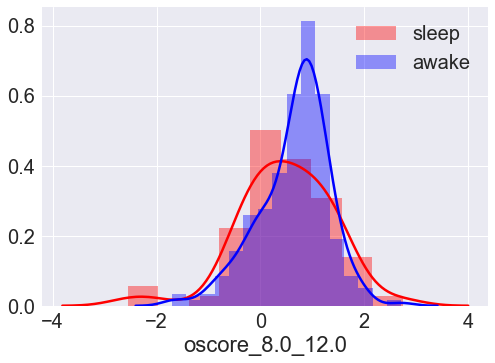

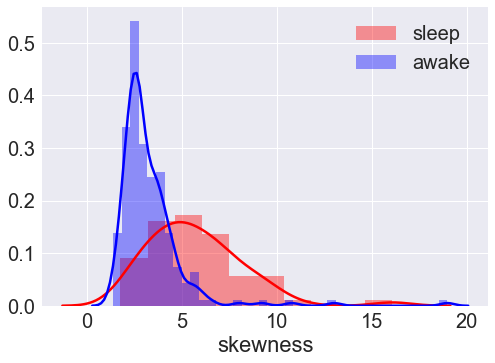

In [140]:
for f in data_bursts.drop(['awake'], axis=1).columns.values:
    plt.figure()
    sns.distplot(data_bursts[data_bursts['awake'] == 0][f], color='red', label='sleep')
    sns.distplot(data_bursts[data_bursts['awake'] == 1][f], color='blue', label='awake')
    plt.legend()

In [141]:
data_bursts.to_csv('data_burst_with_log.csv', index=False)

In [104]:
data_005 = pd.read_excel('../sleep_1..xls')
data_005 = data_005[data_005['burst_oscore_12.0_20.0'] > 0.]

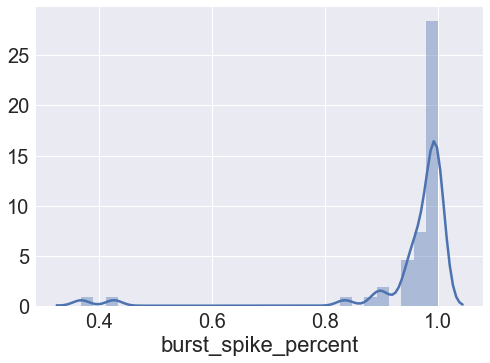

In [105]:
sns.distplot(data_005['burst_spike_percent'])